# DAT257x: Reinforcement Learning Explained

## Lab 2: Bandits

### Exercise 2.3: UCB

In [10]:
import numpy as np
import sys

if "../" not in sys.path:
    sys.path.append("../") 

from lib.envs.bandit import BanditEnv
from lib.simulation import Experiment

In [11]:
#Policy interface
class Policy:
    #num_actions: (int) Number of arms [indexed by 0 ... num_actions-1]
    def __init__(self, num_actions):
        self.num_actions = num_actions
    
    def act(self):
        pass
        
    def feedback(self, action, reward):
        pass

In [12]:
#Greedy policy
class Greedy(Policy):
    def __init__(self, num_actions):
        Policy.__init__(self, num_actions)
        self.name = "Greedy"
        self.total_rewards = np.zeros(num_actions, dtype = np.longdouble)
        self.total_counts = np.zeros(num_actions, dtype = np.longdouble)
    
    def act(self):
        current_averages = np.divide(self.total_rewards, self.total_counts, where = self.total_counts > 0)
        current_averages[self.total_counts <= 0] = 0.5      #Correctly handles Bernoulli rewards; over-estimates otherwise
        current_action = np.argmax(current_averages)
        return current_action
        
    def feedback(self, action, reward):
        self.total_rewards[action] += reward
        self.total_counts[action] += 1

In [13]:
#Epsilon Greedy policy
class EpsilonGreedy(Greedy):
    def __init__(self, num_actions, epsilon):
        Greedy.__init__(self, num_actions)
        if (epsilon is None or epsilon < 0 or epsilon > 1):
            print("EpsilonGreedy: Invalid value of epsilon", flush = True)
            sys.exit(0)
            
        self.epsilon = epsilon
        self.name = "Epsilon Greedy"
    
    def act(self):
        choice = None
        if self.epsilon == 0:
            choice = 0
        elif self.epsilon == 1:
            choice = 1
        else:
            choice = np.random.binomial(1, self.epsilon)
            
        if choice == 1:
            return np.random.choice(self.num_actions)
        else:
            current_averages = np.divide(self.total_rewards, self.total_counts, where = self.total_counts > 0)
            current_averages[self.total_counts <= 0] = 0.5  #Correctly handles Bernoulli rewards; over-estimates otherwise
            current_action = np.argmax(current_averages)
            return current_action
        

Now let's implement a UCB algorithm. 



In [26]:
#UCB policy
class UCB(Greedy):
    def __init__(self, num_actions):
        Greedy.__init__(self, num_actions)
        self.name = "UCB"
        self.round = 0
        self.ucb = np.zeros(num_actions, dtype = np.longdouble)
        
    def act(self):
        current_action = None
        self.round += 1
        if self.round <= self.num_actions:
            current_action = self.round - 1
        else:
            """At round t, play the arms with maximum average and exploration bonus"""
            current_averages = np.divide(self.total_rewards, self.total_counts, where = self.total_counts > 0)
            current_averages[self.total_counts <= 0] = 0.5
            ucb = current_averages + np.sqrt(2*np.log(self.round)/self.total_counts)
            current_action = np.argmax(ucb)
        return current_action

Now let's prepare the simulation. 

In [27]:
evaluation_seed = 1239
num_actions = 10
trials = 10000
distribution = "bernoulli"


What do you think the regret graph would look like?

Distribution: bernoulli [0.5061565  0.74836123 0.53065236 0.37446716 0.88168477 0.83849367
 0.3951277  0.13217982 0.44509856 0.03459039]
Optimal arm: 4


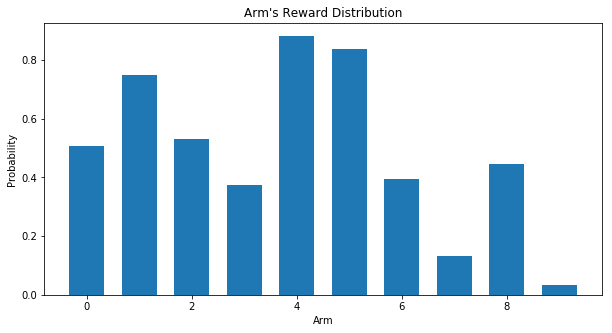

--------------------------------------------------
Policy: UCB 
Average Reward: 0.8354 
Average Regret: 0.04188534959342253
Arm pulls: [  98.  806.  112.   44. 6490. 2235.   79.   28.   84.   24.]


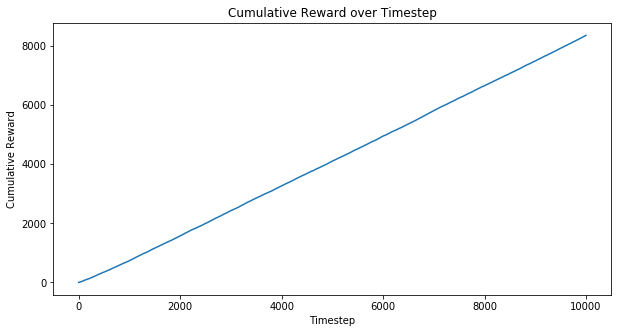

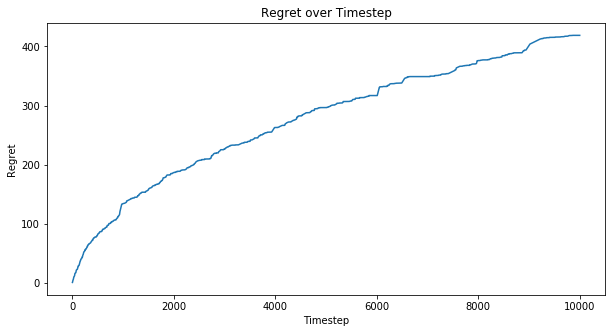

In [28]:
env = BanditEnv(num_actions, distribution, evaluation_seed)
agent = UCB(num_actions)
experiment = Experiment(env, agent)
experiment.run_bandit(trials)